# CPSC 475 Final Project
## David Hidalgo-Gato and Owen Marks

## The Task
**What is our project about, and why is it interesting?**

Our project stemmed from an interest in training convolutional neural networks to identify higher-level features in images. We were able to find a relatively comprehensive dataset containing the paintings of and information on 50 world famous artists, including  a dataframe of their genre, nationality, a brief summary on their works, and a folder of the most famous paintings corresponding to that artist. Though there are many different focus points with which to train a network on this dataset, we were particularly interested in whether we could, given an artwork, identify which artist painted that artwork to a certain level of precision. 

The main idea of this project was quite similar to integer assignment we did as a class: given a set of images and classes corresponding to those images, train a network to the point where it can accurately predict the classes of images it has not seen before. The main difference in our project lied in its complexity - Whereas a model trained to identify integers in black and white is primarily focused on object detection, a perfectly-trained artist predictor model should be able to see two paintings of the same image -- a house, for example -- and differentiate them based on who painted each. This requires a deep and specific knowledge of what makes each artist unique, which goes far beyond simple object detection or color differentiation.

In [43]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import random
from sklearn.model_selection import train_test_split
from PIL import Image

## The Data
**What does the data consist of?
What are some things we had to keep in mind?**

As mentioned in our introduction, the dataset originally consisted of 50 unique artists, each with a host of information corresponding to them and a folder of paintings they created. Since we assumed the network would struggle with learning about artists with an insufficient number of paintings, we decided to limit our data to artists with over 100 paintings in the dataset. We also had to remove one artist (Albrecht Durer) due to issues with processing his name in images. This reduced our number of artists to 29. 

We loaded in many different image sizes for our study, ranging from 32x32 to 100x100. We attempted to increase image size beyond this point, but we encountered technical issues with storage space on our computers and on Google Colaborator (particularly when it came to training models). Several of our models took an extremely long time to run, so we were forced to limit our number of epochs when moving beyond 32x32 images. One of the issues of this endeavor was the lack of computing power to effectively store and process such large amounts of data.

In [44]:
#Get artists df
artists = pd.read_csv("archive/artists.csv")
print(artists.shape)

#Comment out this line to include all artists
artists = artists[artists['paintings'] >= 100]
artists = artists.sort_values(by='paintings', ascending=False).reset_index()[['name','years','genre','nationality','paintings']]

print(artists.shape)
artists.head(10)

(49, 8)
(29, 5)


,name,years,genre,nationality,paintings
0,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,877
1,Edgar Degas,1834 - 1917,Impressionism,French,702
2,Pablo Picasso,1881 - 1973,Cubism,Spanish,439
3,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,336
4,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,311
5,Francisco Goya,1746 - 1828,Romanticism,Spanish,291
6,Rembrandt,1606 - 1669,Baroque,Dutch,262
7,Alfred Sisley,1839 - 1899,Impressionism,"French,British",259
8,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,255
9,Marc Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",239


In [45]:
#Need to collect all images along with their respective artist. First must get all image names
images_path = 'archive/images/images'
artists_names = artists['name'].str.replace(' ','_').values
image_artists = []
all_ims = []



width = 100
height = 100
new_size = ((height, width))

for artist in artists_names:
    artist_images = os.listdir(os.path.join(images_path, artist))

    #loads all images from this artist into array. Resizes to 300x300. Newsize arbitrary right now.
    all_ims.extend([np.asarray(Image.open(os.path.join(images_path, artist, im)).convert('RGB').resize(new_size))/255. for im in artist_images])
    image_artists.extend([artist] * len(artist_images))
    print(artist.replace('_',' ') + ": " + str(len(artist_images)))
    
print("Total images: " + str(len(all_ims)))

Vincent van Gogh: 877
Edgar Degas: 702
Pablo Picasso: 439
Pierre-Auguste Renoir: 336
Paul Gauguin: 311
Francisco Goya: 291
Rembrandt: 262
Alfred Sisley: 259
Titian: 255
Marc Chagall: 239
Rene Magritte: 194
Amedeo Modigliani: 193
Paul Klee: 188
Henri Matisse: 186
Andy Warhol: 181
Mikhail Vrubel: 171
Sandro Botticelli: 164
Leonardo da Vinci: 143
Peter Paul Rubens: 141
Salvador Dali: 139
Hieronymus Bosch: 137
Pieter Bruegel: 134
Diego Velazquez: 128
Kazimir Malevich: 126
Frida Kahlo: 120
Giotto di Bondone: 119
Gustav Klimt: 117
Raphael: 109
Joan Miro: 102
Total images: 6763


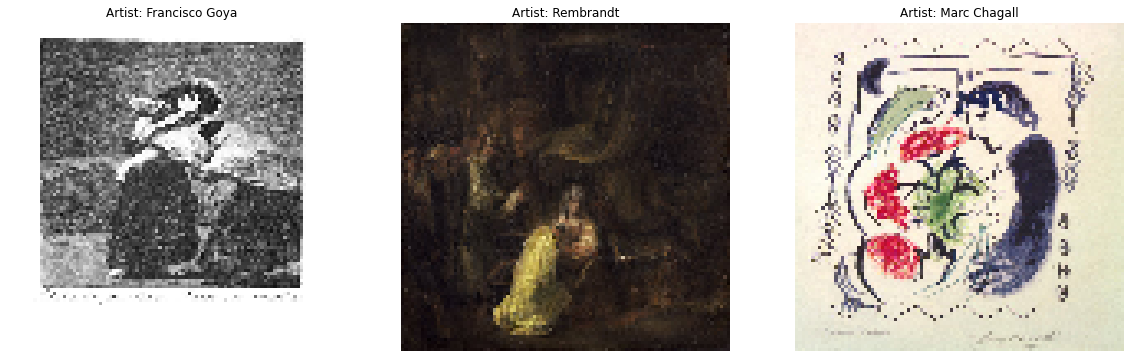

In [46]:
n = 3
fig, axes = plt.subplots(1, n, figsize=(20,10))
for i in range(n):
    random_index = random.choice(range(len(all_ims)))
    artist = image_artists[random_index]
    image = all_ims[random_index]
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Models
**What were our initial approaches?
What did we end up trying?**


A lot of work went into choosing the model(s) we would test on this dataset. We were unsure as to what would work best, so we decided to re-direct our focus towards the *difference* in different types of models' performance as opposed to any individual model success rate. Our primary concern was the question of, "What works better, complexity or simplicity?"

We teseted two types of models on this dataset. For the first, we imported the ResNet50 model from the Python Keras library within Tensorflow. ResNet, short for residual networks, is a standard neural network framework which won the ImageNet challenge in 2015. We imported ResNet50 (with pre-trained ImageNet weights) as a backbone for our model, and added a few layers to collect data and output in the classification format we desired. Our second model was far simpler -- we built off of the original model we had in class, but added a second convolutional layer. We played around with different parameter sizes on the 32x32 images, and decided to go with filter sizes of (3,3) and (5,5) for the convolutional layers respectively, as well as 15 filters for each layer. We also removed the pooling layer because we found that it decreased our performance rates with the 32x32 images. 

Once we refined our approach and model selection, we decided to train each model on different-sized images, altering batch size and number of epochs along the way. Our initial hypothesis was simply that ResNet50 would perform better on all fronts, given that it is a more complex model with a proven track record of success. We have included some results from a trial with 100x100 images and 1 epoch -- the rest of our data has been recorded empirically, and we will comment on it below.

In [47]:
#Get training data sets and testing data sets
#Converting to np arrays is somewhat timely
X = np.array(all_ims)
y = np.array(image_artists)

img_shape = X[0].shape
n_classes = len(np.unique(y))

names_indexes, y_encoded = np.unique(y, return_inverse=True)
y_cat = tf.keras.utils.to_categorical(y_encoded)
 
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20) 

In [21]:
# Load ResNet model and add some layers at end
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)

# Adding layers at end and compiling
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(n_classes, activation= 'softmax')(x)
resmodel = Model(inputs = base_model.input, outputs = predictions)

resmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
{
    "tags": [
        "hide-output",
    ]
}
# train resmodel 
results = resmodel.fit(x=X_train, y=y_train, epochs=1, batch_size=16)

result = resmodel.evaluate(x=X_test, y=y_test)

for name, value in zip(resmodel.metrics_names, result):
    print(name, value)

43/43 [==============================] - 24s 560ms/step - loss: 4.6335 - accuracy: 0.0399
loss 4.633534908294678
accuracy 0.03991130739450455


In [63]:
#Build CNN model

# Start construction of the Keras Sequential model.
class_model = Sequential()

# Input layer for setting the shape of the input images
class_model.add(InputLayer(input_shape=img_shape))

# First convolutional layer with ReLU-activation and max-pooling.
class_model.add(Conv2D(kernel_size= (3,3), ### choose kernel size as a 2-tuple, e.g. (5,5) (usually square)
                 strides= 1, ### choose spacing between applications of the filters across image; default is 1
                 filters= 15, ### choose number of filters for this layer
                 padding='same',
                 activation='relu',
                 name='layer_conv1'))

class_model.add(Conv2D(kernel_size= (5,5), ### choose kernel size as a 2-tuple, e.g. (5,5) (usualy square)
                 strides= 1, ### choose spacing between applications of the filters across image; default is 1
                 filters= 15, ### choose number of filters for this layer
                 padding='same',
                 activation='relu',
                 name='layer_conv2'))

#class_model.add(MaxPooling2D(pool_size=(2,2), strides=2))


# Flatten the output of the convolutional layers
# so it can be used as input to a fully-connected / dense layer.
class_model.add(Flatten())

class_model.add(Dense(64, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
class_model.add(Dense(n_classes, activation='softmax'))

class_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
{
    "tags": [
        "hide-output",
    ]
}
results = class_model.fit(x=X_train, y=y_train, epochs=10, batch_size=16)

result = class_model.evaluate(x=X_test, y=y_test)

for name, value in zip(class_model.metrics_names, result):
    print(name, value)

Epoch 1/10
339/339 [==============================] - 86s 253ms/step - loss: 3.0939 - accuracy: 0.1869
Epoch 2/10
339/339 [==============================] - 87s 255ms/step - loss: 2.1490 - accuracy: 0.3980
Epoch 3/10
339/339 [==============================] - 88s 259ms/step - loss: 0.9095 - accuracy: 0.7510
Epoch 4/10
339/339 [==============================] - 88s 260ms/step - loss: 0.1985 - accuracy: 0.9492
Epoch 5/10
339/339 [==============================] - 88s 258ms/step - loss: 0.0536 - accuracy: 0.9900
Epoch 6/10
339/339 [==============================] - 88s 259ms/step - loss: 0.0228 - accuracy: 0.9957
Epoch 7/10
339/339 [==============================] - 94s 278ms/step - loss: 0.0208 - accuracy: 0.9969
Epoch 8/10
339/339 [==============================] - 109s 322ms/step - loss: 0.0156 - accuracy: 0.9972
Epoch 9/10
339/339 [==============================] - 100s 296ms/step - loss: 0.0230 - accuracy: 0.9954
Epoch 10/10
43/43 [==============================] - 5s 109ms/step - lo

In [65]:
best_model = class_model
test_preds = np.argmax(best_model.predict(X_test),axis=1)
test_labels = np.argmax(y_test,axis=1)
correct_idx = np.where(np.equal(test_preds, test_labels))[0] #np.where(test_preds == test_labels)
incorrect_idx = np.where(~np.equal(test_preds, test_labels))[0]

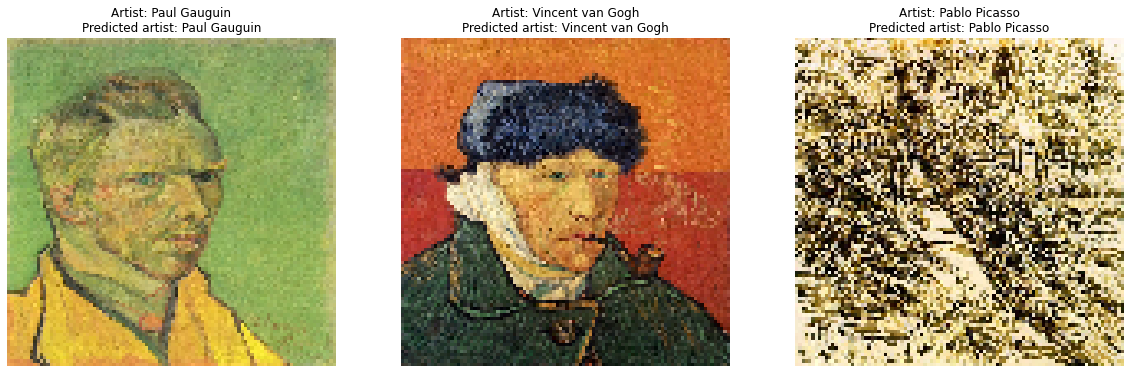

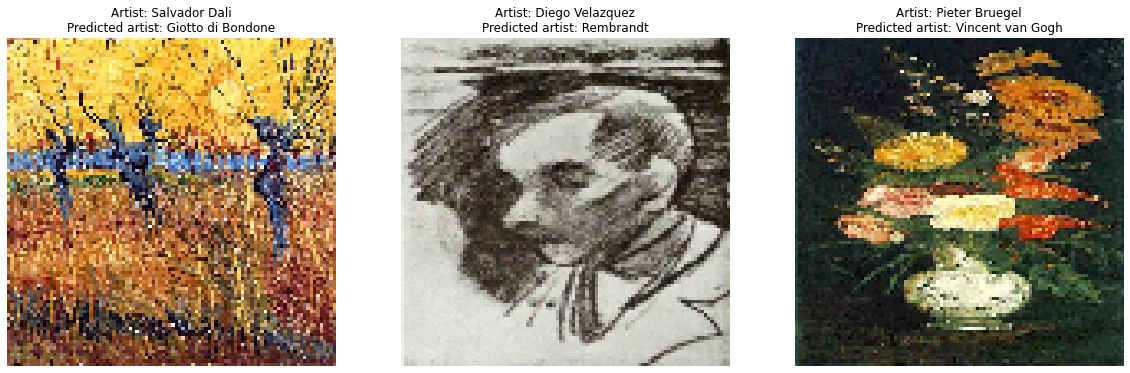

In [67]:
#Correctly classified images
n = 3
fig, axes = plt.subplots(1, n, figsize=(20,10))
for i in range(n):
    correct_to_display = random.choice(correct_idx)
    correct_artist = names_indexes[test_labels[correct_to_display]]
    predicted_artist = names_indexes[test_preds[correct_to_display]]
    image = all_ims[correct_to_display]
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + correct_artist.replace('_', ' ') +\
                     "\nPredicted artist: " + predicted_artist.replace('_', ' '))

    axes[i].axis('off')
plt.show()

#Incorrectly classified images
n = 3
fig, axes = plt.subplots(1, n, figsize=(20,10))
for i in range(n):
    incorrect_to_display = random.choice(incorrect_idx)
    incorrect_artist = names_indexes[test_labels[incorrect_to_display]]
    predicted_artist = names_indexes[test_preds[incorrect_to_display]]
    image = all_ims[incorrect_to_display]
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + incorrect_artist.replace('_', ' ') +\
                     "\nPredicted artist: " + predicted_artist.replace('_', ' '))

    axes[i].axis('off')
plt.show()

In [68]:
#Model results -- found empirically

resnet_1x32 = [13.5,11.2,4.8,4.07]
class_1x32 = [22.17,23.2,24.7,20.1]
resnet_10x32 = [15.22,21.78,23.54,30.87]
class_10x32 = [29.95,30.37,33.54,29.67]

resnet_1x64 = [13.23,13.3,4.28,3.0]
class_1x64 = [19.96,25.1,28.9,26.9]

resnet_1x100 = [13.6,9.1,2.8,13.8]
class_1x100 = [22.4,23.1,23.4,19.8]

resnet_errors = [resnet_1x32,resnet_10x32,resnet_1x64,resnet_1x100]
class_errors = [class_1x32,class_10x32,class_1x64,class_1x100]

pxl_dims = [32,32,64,100]
batches = [4,8,16,32]
epochs = [1,10,1,1]


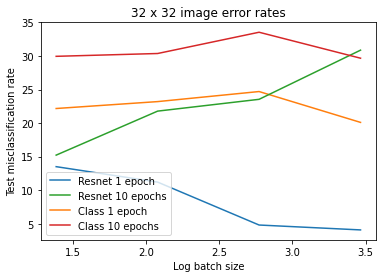

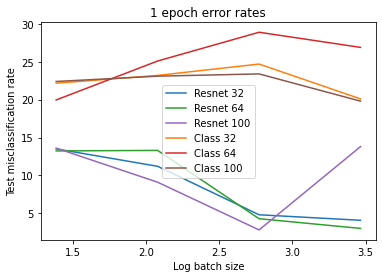

In [12]:
#32 pixel errors, 1 and 10 epochs
line_p1, = plt.plot(np.log(batches), resnet_1x32, label='Resnet 1 epoch')
line_p2, = plt.plot(np.log(batches), class_1x32, label='Class 1 epoch')
line_p3, = plt.plot(np.log(batches), resnet_10x32, label='Resnet 10 epochs')
line_p4, = plt.plot(np.log(batches), class_10x32, label='Class 10 epochs')
plt.legend(handles=[line_p1, line_p3, line_p2, line_p4])
plt.xlabel("Log batch size")
plt.ylabel("Test Classification Rate")
plt.title("32 x 32 Image Success Rates")
plt.show()

# 1 Epoch error rates
line_p1, = plt.plot(np.log(batches), resnet_1x32, label='Resnet 32')
line_p2, = plt.plot(np.log(batches), class_1x32, label='Class 32')
line_p3, = plt.plot(np.log(batches), resnet_1x64, label='Resnet 64')
line_p4, = plt.plot(np.log(batches), class_1x64, label='Class 64')
line_p5, = plt.plot(np.log(batches), resnet_1x100, label='Resnet 100')
line_p6, = plt.plot(np.log(batches), class_1x100, label='Class 100')
plt.legend(handles=[line_p1, line_p3, line_p5, line_p2, line_p4, line_p6])
plt.xlabel("Log Batch Size")
plt.ylabel("Test Classification Rate")
plt.title("1 Epoch Success Rates")
plt.show()

## Results
**Which model worked better in which scenarios? Why might this be the case?
Which parameters seemed to have a large effect on the model accuracy and which did not?**

Our results were slightly disappointing, though very interesting nonetheless. We were unable to achieve a success rate of over 33.54% with the class model, which was achieved with 32x32 images, 10 epochs, and a batch size of 16. We were extremely intrigued by the fact that the class model appeared to perform better than the ResNet50 model on all fronts. With low levels and higher batch sizes, the ResNet model performed terribly -- its results were essentially random (we had 29 artists to predict, so a random agent would be correct roughly 3.5% of the time... the ResNet model, under these conditions, was accurate about 4% of the time). When we increased frequency to 10 epochs, the ResNet model performed much better, while the class model's performance only improved slightly. It appeared that the ResNet model required more data and more epochs to function appropriately, which makes sense -- with more information, a more complex model is likely to fair significantly better, while a simpler model runs the risk of overtraining. 

We found that the parameter with the largest impact on the model accuracy was the number of epochs, particulary with the ResNet50 model. Naturally, as the model continued to train on the images, it was exposed to more data and gained an opportunity to develop more accurate weights. With the class model, however, number of epochs didn't have as great of an effect -- this is likely due to the fact that the class model was much simpler, and therefore became accustomed to the data more quickly. Repeated exposure to the data would increase the accuracy of the class model on the training data but did not end up having a drastic impact on its performance with images it hadn't seen before.

## Conclusion and Future Directions
**Did we answer our initial question?
If we had more time/resources, what would we have liked to have experimented with?**


Our initial question of whether or not a model could identify artists' painting style was replaced by examining which of the different aspects of a model were most important to its success. But even this question leaves us with more to ask. If we had the computing power and time to train more models, we expect that we would be able to achieve accuracies much higher than that of our best model here. Specifically, we think that the ResNet50 model's performance would overcome that of the simpler class model given larger image sizes and more epochs. Since the ResNet model is so complex and contains so many more weights, it likely needs more time to train each of those weights effectively than the smaller, manually-built model does. 

Other questions that would be interesting to try and answer is how well these models could identify the genres, nationalities, or time periods of these paintings rather than their artists. We hypothesize that a model well-trained to identify artists would also perform strongly with these other differentiating components of artwork, as the model will have likely picked up on key components that make images unique.